# Membrane potentials

In [1]:
"""Further command line arguments:
        c       script will close all open plots
        sli     data of the original simulation written in sli will be analyzed. 
                Note that at this point, the data must be of the same simulation type, 
                as specifications are loaded from .npy-files of the pynest simulation. 

    Overview over all populations: Raster plot, mean rates, mean CV of ISI per population.
"""
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import model_class; reload(model_class)

%matplotlib inline

show_fig = False
save_fig = True
xfactor = 2.6
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
colors = style.colors

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 6 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


In [2]:
# DATA
sim_spec = "membrane_potential_fixindeg"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

## Plot membrane potentials

save figure to single_membrane_potential_L23e


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


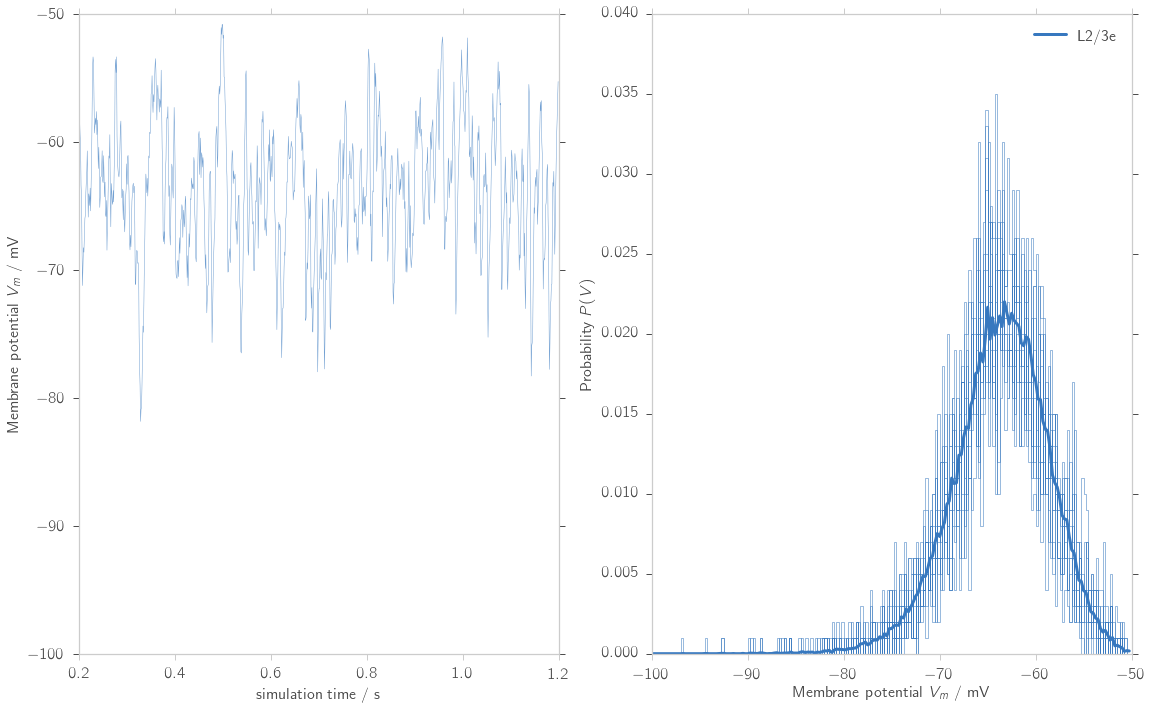

In [3]:
with h5py.File(path_res_file, "r") as res_file:
    res_grp = res_file["0"]
    
    dset_times_volt     = res_grp["times_volt"]
    times_volt = dset_times_volt[:]
    t_min_volt = dset_times_volt.attrs["t_min_volt"]
    t_max_volt = dset_times_volt.attrs["t_max_volt"]
    dt_volt    = dset_times_volt.attrs["dt_volt"]
    
    volt_plot         = res_grp["volt_plot"][:]
    volt_histo_single = res_grp["volt_histo_single"][:]
    volt_histo_means  = res_grp["volt_histo_means"][:]
    n_hist_max  = res_grp.attrs["n_hist_max"]
    V_min       = res_grp.attrs["V_min"]
    V_max       = res_grp.attrs["V_max"]
    n_bins_volt = res_grp.attrs["n_bins_volt"]
    n_neurons_rec_voltage = res_grp.attrs["n_neurons_rec_voltage"][:]
    
bin_edges = np.linspace(V_min, V_max, n_bins_volt + 1) 

fig = plt.figure()
if not save_fig:
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec
    if sli: 
        suptitle += '  SLI'
    fig.suptitle(suptitle, y=0.98)
# Membrane pot over time
ax0 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
# Histogram of membrane pot
ax1 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

for i, population in enumerate(populations):
    if i==0:
        j = 0
        volt_single = volt_plot[i][j]
        ax0.plot(times_volt, volt_single, 
            '-', color=colors[i], alpha=0.7, linewidth=0.5, label=hf.rlbl(population))
        
        # Histograms
        # Normalization
        
        for j in range(n_hist_max):
            # Normalization
            single_hist_normed = volt_histo_single[i, j] / np.sum(volt_histo_single[i, j])
            ax1.plot(bin_edges[:-1], single_hist_normed, 
                 linewidth=1., color=colors[i], alpha=0.5, drawstyle="steps")
        hist_normed = volt_histo_means[i] / np.sum(volt_histo_means[i])
        ax1.plot(bin_edges[:-1], hist_normed, linewidth=3., color=colors[i], label=hf.rlbl(population))
        
# Potential over time
xlim = np.array([t_min_volt, t_max_volt]) # s
ax0.set_xlabel('simulation time / s')
ax0.set_ylabel('Membrane potential $V_m$ / mV')
ax0.set_xlim(*xlim)
ax0.set_ylim(V_min, V_max)

# Histogram
ax1.set_xlabel('Membrane potential $V_m$ / mV')
ax1.set_ylabel('Probability $P(V)$')
ax1.set_xlim(V_min, V_max)
#ax1.set_ylim(0, 0.15)

ax1.legend(loc=0)
    
for ax in fig.axes:
    ax.grid(False)
    style.fixticks(ax)
    
fig_name = "single_membrane_potential"
fig_name += "_L23e"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name)  

## Mean field model solution:

In [4]:
# %load "../analysis/trans_mean_field.py"
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               root_function=None,
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root
    # Instantiation
    if jacobian:
        jac = model.jacobian
    else:
        jac = False

    # Run on initial guess v_guess_0
    if root_function=="siegert":
        sol = root(model.root_v0_siegert, v_guess_0, jac=jac, method=root_method, options=options)
    else:
        sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        print("intial success")
        v0  = sol["x"]
        if np.all(v0 < 1./model.t_ref): 
            return v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")
        
#######################################################
# Global boundaries
#######################################################
connection_rule = "fixed_indegree"
PSC_rel_sd      = 0.0
model_micro       = model_class.model(connection_rule=connection_rule,
                                           PSC_rel_sd=PSC_rel_sd) 
v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])

t_int0      = time.time()
rate_mf = solve_model(model_micro, v_guess_0)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

intial success
Integration time: 0.03


In [5]:
def prob_V(V_array, mu_i, sd_i, v0_i, model=model_class.model()):
    """Membrane potential probability distribution P(V_m) according to Brunel"""
    from scipy.integrate import quad
    step        = lambda x: 0.5 * (np.sign(x) + 1)  # Heaviside step function
    red         = lambda V: (V - mu_i) / sd_i           # reduced voltage
    P_integrand = lambda u: step(u - red(model.V_r)) * np.exp(u**2) # integrand
    
    Vs = V_array - model.E_L # shift since Brunel's model is using E_L = 0
    
    # Integral boundaries
    lowers  = red(Vs)
    upper  = red(model.theta)
  
    integrals   = np.array([quad(P_integrand, lower, upper)[0] for lower in lowers])

    P_V_array   = 2 * v0_i * model.tau_m / sd_i * np.exp(- (Vs - mu_i)**2 / sd_i**2) * integrals
    
    return step(-Vs + model.theta) * P_V_array

In [6]:
def plot_membrane_potential(path_res_file, rate_mf, 
                            figsize=(xfactor*6.2, 2*xfactor*3.83), 
                            figname="membrane_potential"):
    # Model
    connection_rule = "fixed_indegree"
    PSC_rel_sd      = 0.1 # 0.1 for micro
    model           = model_class.model(connection_rule=connection_rule,
                                               PSC_rel_sd=PSC_rel_sd) 

    # Get voltage data
    with h5py.File(path_res_file, "r") as res_file:
        sim_spec2 = "0"
        res_grp = res_file[sim_spec2]
        # Rates
        rates_mean   = res_grp["rates_mean"][:]
        rates_std    = res_grp["rates_std"][:]
        # Voltage
        dset_times_volt     = res_grp["times_volt"]
        t_min_volt = dset_times_volt.attrs["t_min_volt"]
        t_max_volt = dset_times_volt.attrs["t_max_volt"]
        dt_volt    = dset_times_volt.attrs["dt_volt"]
        volt_histo_means  = res_grp["volt_histo_means"][:]
        V_min       = res_grp.attrs["V_min"]
        V_max       = res_grp.attrs["V_max"]
        n_bins_volt = res_grp.attrs["n_bins_volt"]
        n_neurons_rec_voltage = res_grp.attrs["n_neurons_rec_voltage"][:]

    # Input according to Brunel
    mu_brunel   = model.mu(rate_mf)
    sd_brunel   = model.sd(rate_mf)
    # and with simulated input
    mu_sim      = model.mu(rates_mean)
    sd_sim      = model.sd(rates_mean)
    
    # Voltage: Index of V = E_L
    V_step = (V_max - V_min) / n_bins_volt
    V_array = np.arange(V_min, V_max, V_step)
    V_r_arg = np.argmin(np.abs(V_array - (model.V_r + model.E_L))) # Index of neurons in refractory period
    n_t = (t_max_volt - t_min_volt) / dt_volt # number of time bins

    # Figure
    fig = plt.figure(figsize=figsize)
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    ymax = 0.17 # max height for each population
    # Labels
    marker_sim = "-"
    marker_mf  = "--"
    ax1.plot([0, 0], [0, 0], marker_sim, color="gray", label="simulated") 
    ax1.plot([0, 0], [0, 0], marker_mf, color="gray", label="mean field")

    for i, population in enumerate(populations):
        # Get integral form normalization (before taking out neurons in ref. period!)
        norm_factor = np.sum(volt_histo_means[i]) * V_step

        # Remove neurons in refractory period!
        with h5py.File(path_res_file, "r") as res_file:
            single_rates = res_file["0/single_rates/" + population][:n_neurons_rec_voltage[i]]

        P_V_data =  volt_histo_means[i].copy()
        P_V_data[V_r_arg] -= np.sum(single_rates) * model.t_ref * n_t
        P_V_data_normed = P_V_data / norm_factor

        # Theoretical distirbution using Brunel's mu and sd but measured rate v0
        #P_V_theo = prob_V(V_array, mu_sim[i], sd_sim[i], rates_mean[i], model=model)
        P_V_theo = prob_V(V_array, mu_brunel[i], sd_brunel[i], rate_mf[i], model=model)

        # calculate integral of P_theo(V)
        P_cum = np.sum(P_V_data_normed) * V_step
        P_cum_theo = np.sum(P_V_theo) * V_step

        # Plotting
        if reverse_order:
            offset = (n_populations - (i + 1)) * ymax
        else:
            offset = i * ymax
        ax1.plot(V_array, P_V_data_normed + offset, marker_sim, color=colors[i])
        ax1.plot(V_array, P_V_theo + offset, marker_mf, color=colors[i])
        ax1.plot(V_array[[0, -1]], [offset]*2, "--", color="gray")

    # Axes label, etc.
    ax1.set_xlabel('Membrane potential $V_m$ / mV')
    ax1.set_ylabel('Probability $P(V)$')
    ax1.set_ylim(0, n_populations * ymax)
    ax1.set_xlim(-80, V_max)
    ax1.grid(False)
    ax1.legend(loc='best')

    # Create ticks manually
    n_ticks = 4
    ytickmax = ymax - 0.01
    yto           = np.arange(0, ytickmax, ytickmax/n_ticks)
    yt_offset     = np.repeat(np.arange(0,  n_populations * ymax, ymax), n_ticks)
    y_ticks = np.tile(yto, n_populations) + yt_offset
    y_ticklabels = np.tile(yto, n_populations)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)   

    # Population labels
    ax2 = ax1.twinx()
    ax2.set_ylabel('Population')
    ax2.set_yticks(np.arange(0.5, 8, 1)* ymax) 
    yticklabels = hf.rlbl(populations)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ax2.set_yticklabels(yticklabels)
    ax2.set_ylim(0, n_populations * ymax)
    ax2.grid(False)

    for ax in fig.axes:
        style.fixticks(ax)

    fig_name = "membrane_potential"
    if save_fig:
        hf.saving_fig(fig, figure_path, fig_name, verbose=False)  

# Simulated: fixed_total_number

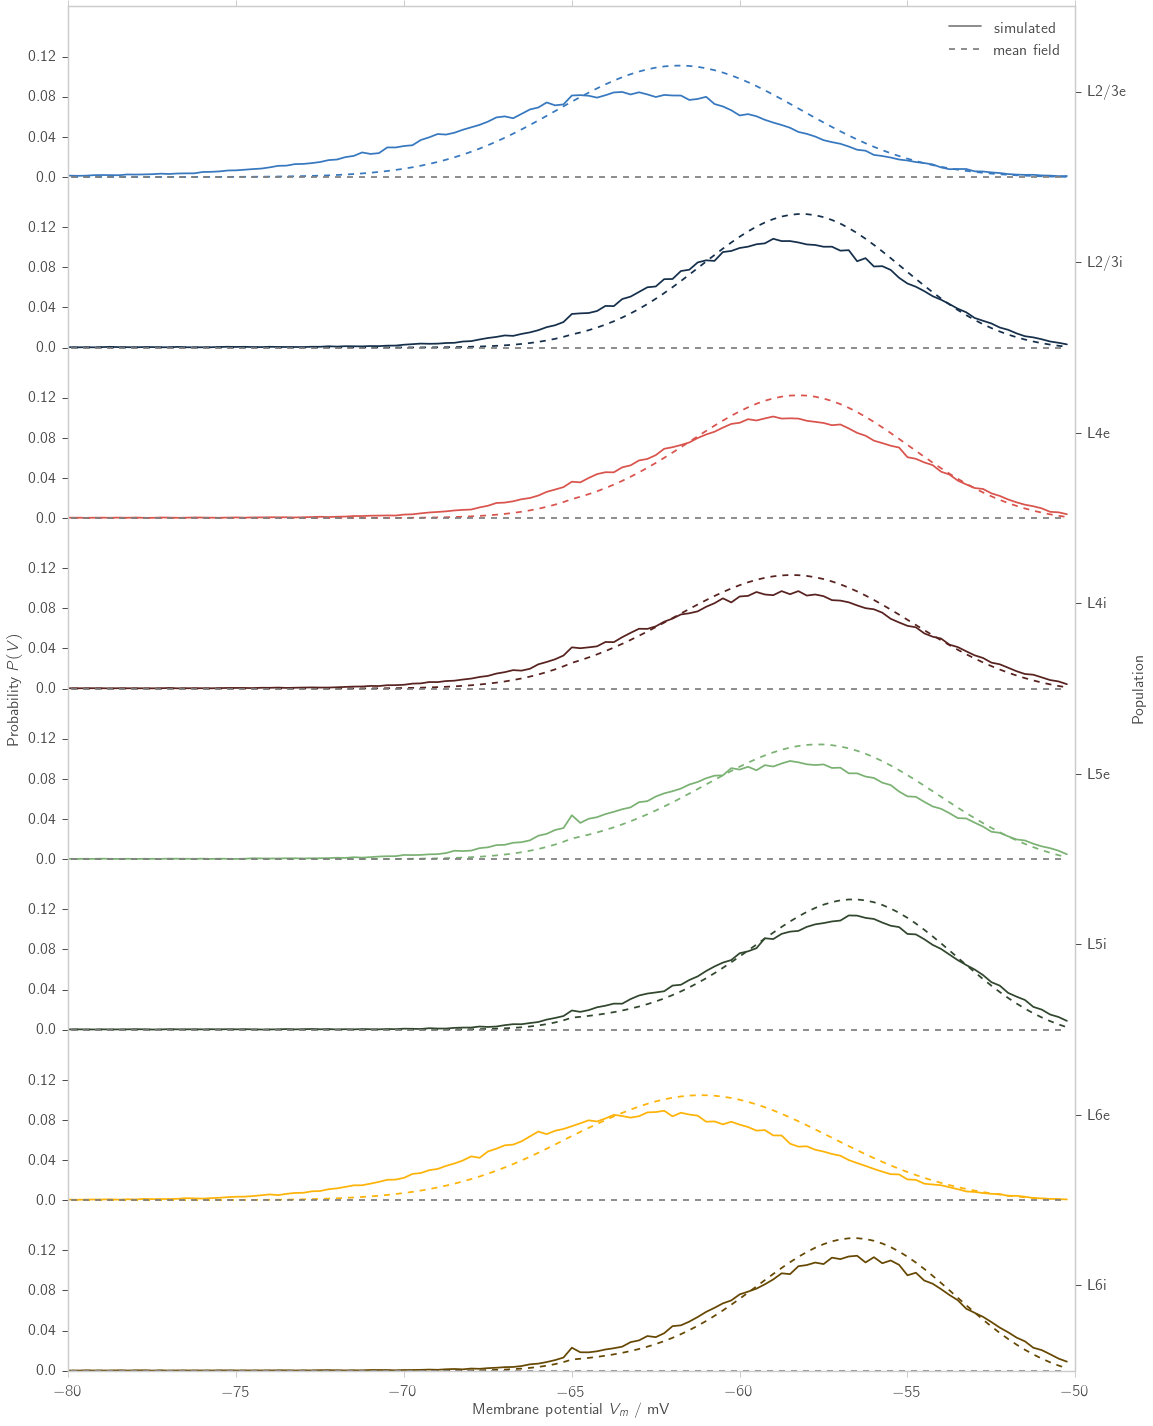

In [7]:
sim_spec = "membrane_potential"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

plot_membrane_potential(path_res_file, rate_mf, figsize=(xfactor*6.2, 2*xfactor*3.83), figname="membrane_potential")

# Simulated: fixed_indegree

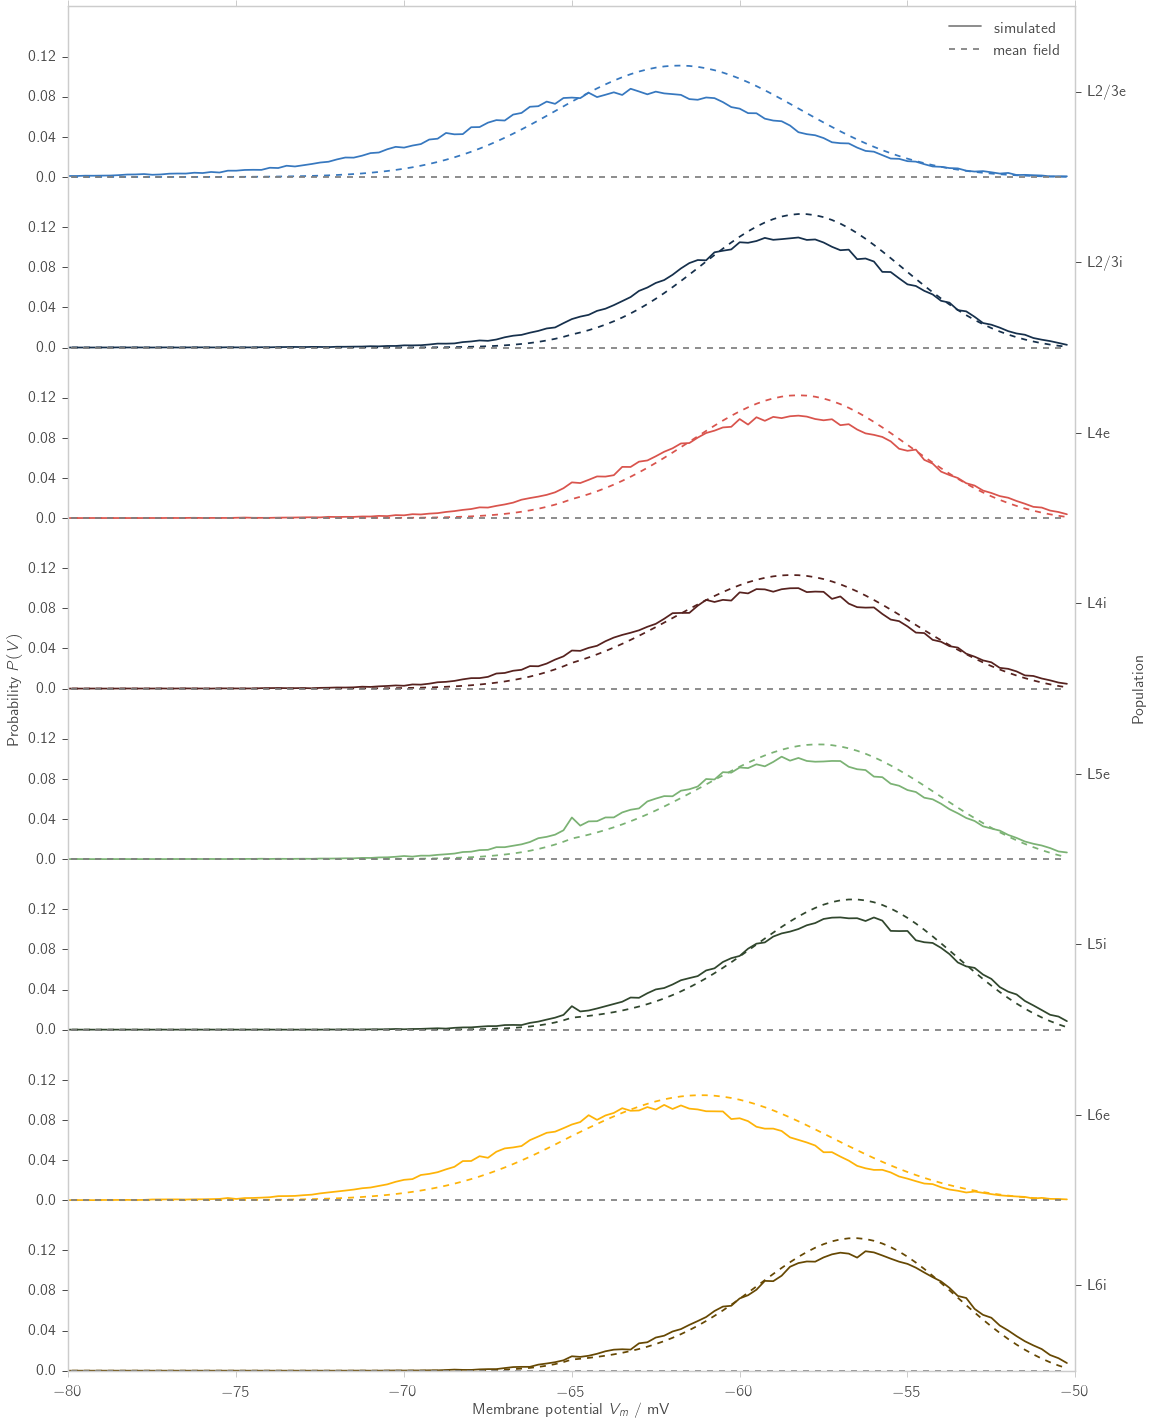

In [8]:
sim_spec = "membrane_potential_fixindeg"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

plot_membrane_potential(path_res_file, rate_mf, figsize=(xfactor*6.2, 2*xfactor*3.83), figname="membrane_potential_fixindeg")

L23e 0.569112274562 3.25017878378 5.10414608171 2.30201507326 1.50002076002


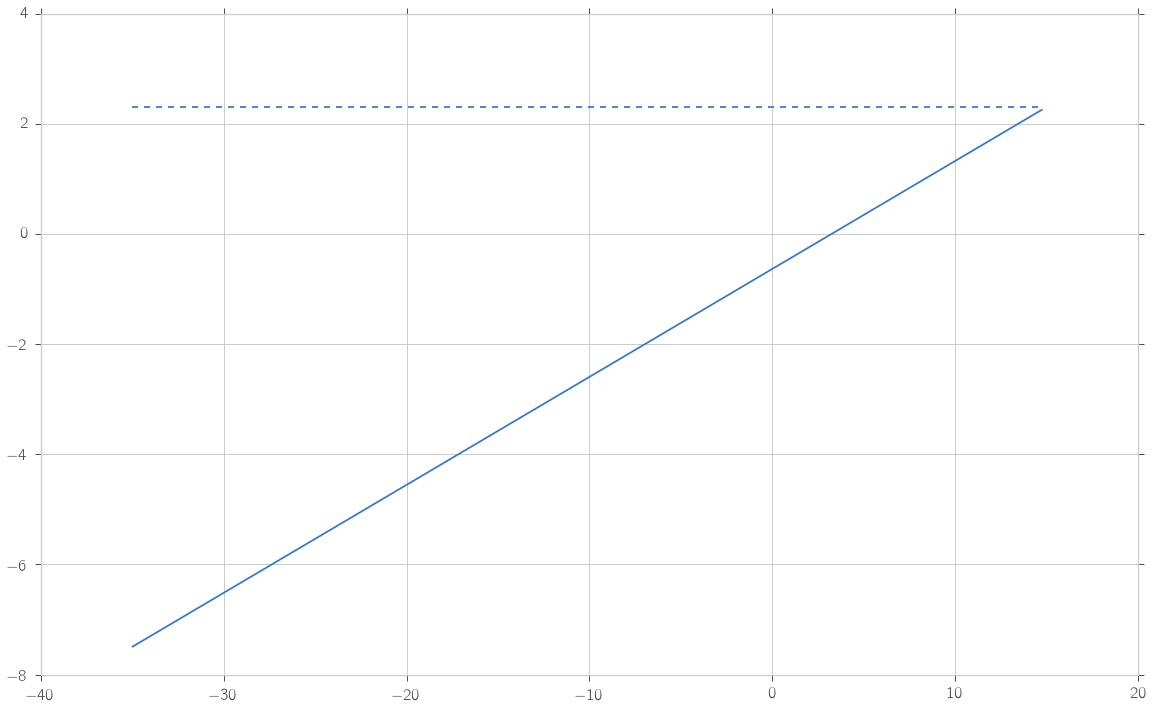

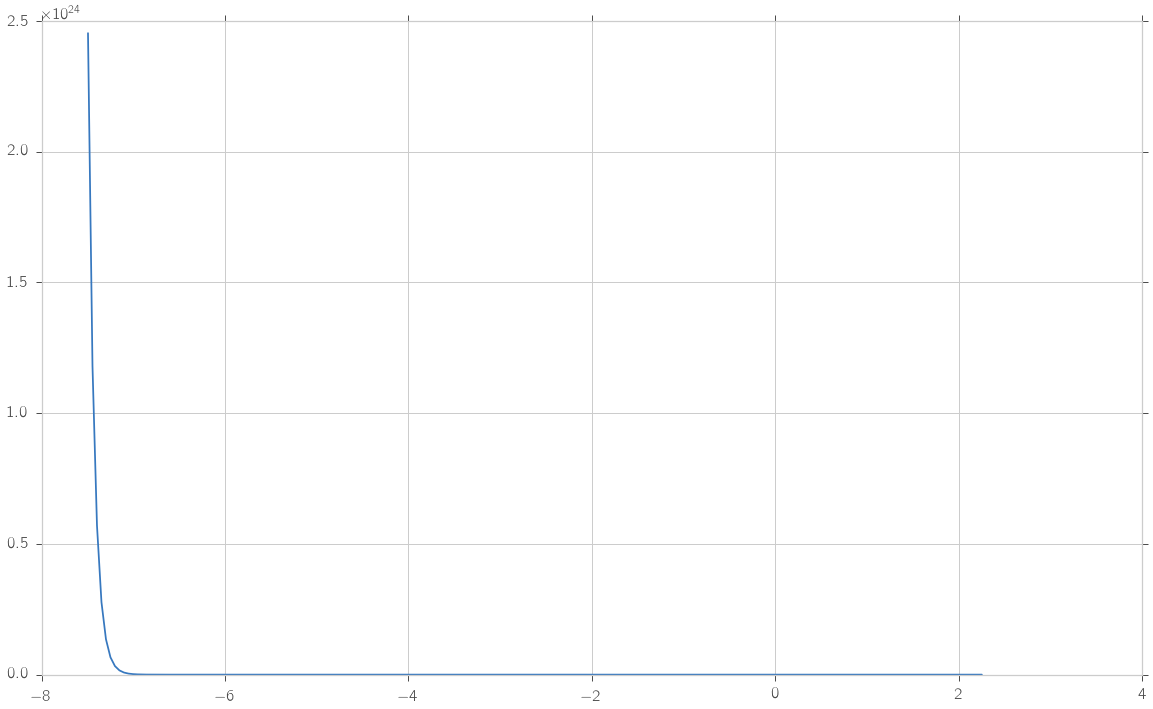

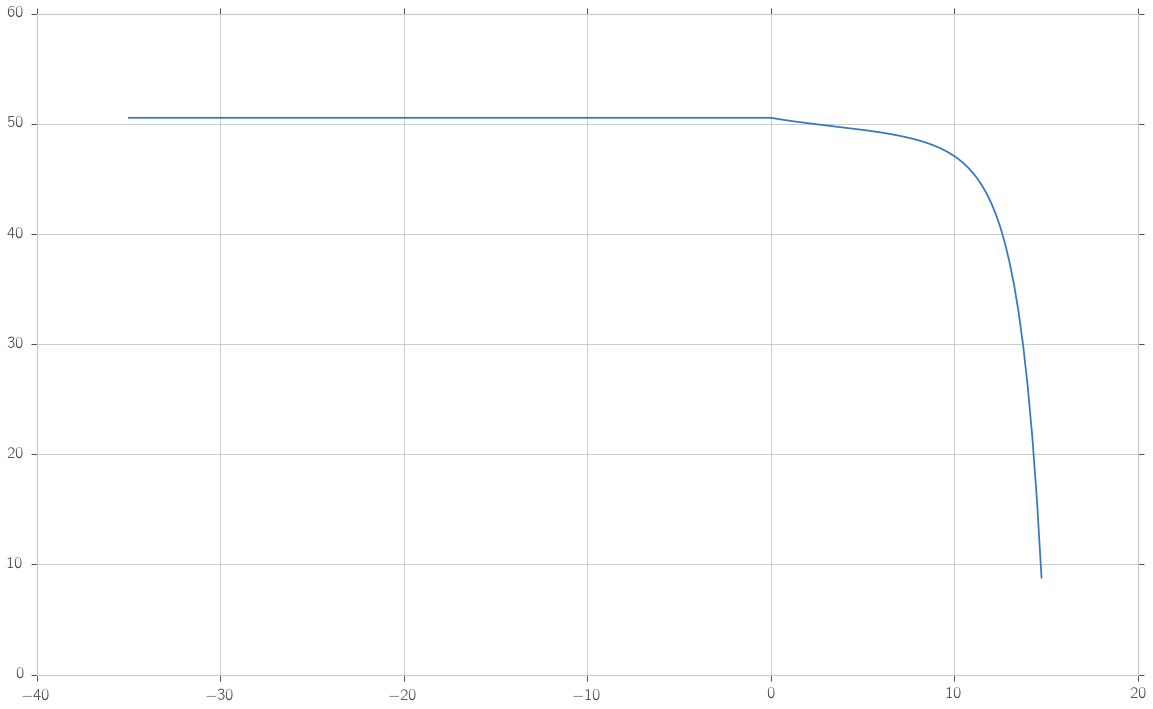

In [9]:
# Model
connection_rule = "fixed_indegree"
PSC_rel_sd      = 0.1 # 0.1 for micro
model           = model_class.model(connection_rule=connection_rule,
                                           PSC_rel_sd=PSC_rel_sd) 
V_array = bin_edges[:-1] 
Vs = V_array - model.E_L # shift since Brunel's model is using E_L = 0
    
mu_brunel   = model.mu(rate_mf)
sd_brunel   = model.sd(rate_mf)


"""Membrane potential probability distribution P(V_m) according to Brunel"""
from scipy.integrate import quad

#for i, population in enumerate(populations):
i = 0
population = populations[i]
if True:
    v0_i = rate_mf[i]
    mu_i = mu_brunel[i]
    sd_i = sd_brunel[i]
    
    step        = lambda x: 0.5 * (np.sign(x) + 1)  # Heaviside step function
    red         = lambda V: (V - mu_i) / sd_i           # reduced voltage
    P_integrand = lambda u: step(u - red(model.V_r)) * np.exp(u**2) # integrand

    # Integral boundaries
    lowers  = red(Vs)
    upper  = red(model.theta)

    integrals   = np.array([quad(P_integrand, lower, upper)[0] for lower in lowers])

    #P_V_array   = 2 * v0_i * model.tau_m / sd_i * np.exp(- (Vs - mu_i)**2 / sd_i**2) * integrals

    fig = plt.figure()
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    ax1.plot(Vs, lowers, "-", color=colors[i], label=hf.rlbl(population))
    ax1.plot(Vs, [upper]*len(Vs), "--", color=colors[i], label=hf.rlbl(population))
    
    fig = plt.figure()
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    ax1.plot(red(Vs), np.exp(((Vs - mu_i) / sd_i)**2), "-", color=colors[i], label=hf.rlbl(population))
    #ax1.set_xlim(mu_i / sd_i, )
    #ax1.set_ylim(0, np.exp(((model.V_r - mu_i) / sd_i)**2))    
    
    fig = plt.figure()
    ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    ax1.plot(Vs, integrals, "-", color=colors[i], label=hf.rlbl(population))    
    

    print(population, v0_i, mu_i, sd_i, (model.theta - mu_i) / sd_i, np.exp(((model.V_r - mu_i) / sd_i)**2))
